In [1]:
import pandas as pd
import os

In [2]:
import pickle

In [3]:
# cleaned featured file from v4

In [4]:
all_topics_df = pd.read_csv('all_topics.csv', index_col=0)

In [5]:
all_topics_df.columns

Index(['goal_first_step', 'default_goal_type', 'is_questioned',
       'are_first_steps_known', 'is_time_certain', 'is_certainly_imagined',
       'are_obstackles_expected', 'goal_domain_key_pos', 'goal_name_key_pos',
       'goal_weight', 'goal_words', 'goal_verbs_counter', 'goal_nouns_counter',
       'goal_numr_counter', 'goal_adj_counter', 'goal_digit_counter',
       'goal_aver_word_len', 'label_attractor_knowledge',
       'label_attractor_hard_skill', 'label_attractor_soft_skill',
       'label_attractor_tool', 'label_attractor_community',
       'label_attractor_subjectivity', 'label_attractor_habits',
       'label_attractor_career', 'label_attractor_fixing',
       'label_attractor_art', 'label_attractor_health'],
      dtype='object')

### CNN approach

In [6]:
topics_cnn = all_topics_df[['goal_name_key_pos', 'label_attractor_knowledge',
       'label_attractor_hard_skill', 'label_attractor_soft_skill',
       'label_attractor_tool', 'label_attractor_community',
       'label_attractor_subjectivity', 'label_attractor_habits',
       'label_attractor_career', 'label_attractor_fixing',
       'label_attractor_art', 'label_attractor_health']]

In [7]:
topics_cnn.dropna(inplace=True)

c:\users\vpoletae\appdata\local\continuum\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
from sklearn.model_selection import train_test_split

In [9]:
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [10]:
text = topics_cnn['goal_name_key_pos']
y = topics_cnn.drop(columns = ['goal_name_key_pos'])

In [11]:
# tfidf = TfidfVectorizer()
# X = tfidf.fit_transform(text)

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

In [14]:
token = Tokenizer()
token.fit_on_texts(text)

In [15]:
vocab_size = len(token.word_index) + 1
vocab_size

4619

In [16]:
encoded_text = token.texts_to_sequences(text)

In [17]:
max_len = int()
for i in encoded_text:
    len_ = len(i)
    if len_ > max_len:
        max_len = len_
        
max_len

127

In [18]:
X = pad_sequences(encoded_text, maxlen=max_len, padding='post')

In [19]:
y = y.values

In [20]:
y

array([[0., 1., 1., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       [0., 1., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
vec_size = 100

model = Sequential()
model.add(Embedding(vocab_size, vec_size, input_length=max_len))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu'))

model.add(GlobalMaxPooling1D())

model.add(Dense(11, activation='softmax'))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 127, 100)          461900    
_________________________________________________________________
conv1d (Conv1D)              (None, 126, 32)           6432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 63, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 32)            0         
_________________________________________________________________
dense (Dense)                (None, 63, 32)            1056      
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 32)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 63, 16)            5

In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [28]:
import numpy as np

In [47]:
from sklearn.preprocessing import MinMaxScaler

In [48]:
mms = MinMaxScaler()

In [49]:
X_train = mms.fit_transform(X_train)
X_test = mms.fit_transform(X_test)

In [50]:
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test= np.asarray(X_test)
y_test = np.asarray(y_test)

In [51]:
X_train.shape

(13562, 127)

In [52]:
model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test))

Train on 13562 samples, validate on 3391 samples
Epoch 1/10
13562/13562 [==============================] - 6s 434us/sample - loss: 2912168285.5886 - accuracy: 0.3693 - val_loss: 1998228300.6264 - val_accuracy: 0.0224
Epoch 2/10
13562/13562 [==============================] - 5s 404us/sample - loss: 4368068859.2809 - accuracy: 0.3705 - val_loss: 2957215673.5641 - val_accuracy: 0.0224
Epoch 3/10
13562/13562 [==============================] - 5s 406us/sample - loss: 6389361382.9701 - accuracy: 0.3660 - val_loss: 4172163796.1380 - val_accuracy: 0.8974
Epoch 4/10
13562/13562 [==============================] - 5s 402us/sample - loss: 8804988788.1646 - accuracy: 0.3634 - val_loss: 5690929009.6184 - val_accuracy: 0.8974
Epoch 5/10
13562/13562 [==============================] - 5s 403us/sample - loss: 11793641930.2404 - accuracy: 0.3651 - val_loss: 7545158221.0038 - val_accuracy: 0.0224
Epoch 6/10
13562/13562 [==============================] - 5s 401us/sample - loss: 15565865555.5841 - accuracy:

In [53]:
losses = pd.DataFrame(model.history.history)

In [54]:
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,2.912168e+09,0.369341,1.998228e+09,0.022412
1,4.368069e+09,0.370521,2.957216e+09,0.022412
2,6.389361e+09,0.366023,4.172164e+09,0.897375
3,8.804989e+09,0.363368,5.690929e+09,0.897375
4,1.179364e+10,0.365138,7.545158e+09,0.022412


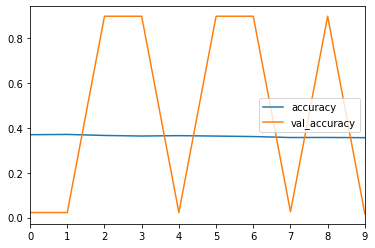

In [55]:
losses[['accuracy','val_accuracy']].plot()

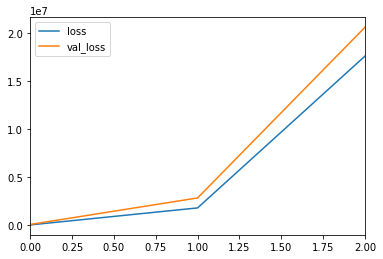

In [34]:
losses[['loss','val_loss']].plot()

In [56]:
print(model.metrics_names)
print(model.evaluate(X_test,y_test,verbose=0))

['loss', 'accuracy']
[23956872491.861988, 0.016219404]


In [37]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score

In [38]:
predictions = model.predict_classes(X_test)

In [40]:
predictions

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)

In [41]:
y_test.shape

(3391, 11)

In [43]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [42]:
len(predictions)

3391

In [44]:
predictions

array([2, 2, 2, ..., 2, 2, 2], dtype=int64)